In [70]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as stats

import torch
import torch.nn as nn
import torch.optim as optim

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample

In [82]:
# Parameters
T = 0.05
N = 200
domain = [0, 1]
sigma_noise = 0.05
mu_u = -1
sigma_2_u = 0.05**2

n = int(0.5*N)
t = np.linspace(domain[0],domain[1], N)
t = np.round(t, 3)
d_k = 40

h = domain[1] / N

n_datasize = 400
dataset = np.zeros((n_datasize, n))
x = np.linspace(domain[0],domain[1], n)

for ii in range(0, n_datasize):
    n_params = np.random.randint(4, 10)
    idxs = np.sort(np.random.randint(0+5, n-5, n_params))
    params = np.sort(np.random.uniform(0, 2, n_params))
    params[::2] = 0
    true = np.zeros(x.shape)

    for jj in range(0, len(idxs[1:])):
        true[idxs[jj-1]:idxs[jj]] = params[jj]

    dataset[ii, :] = true


In [83]:
import arviz as az

from models import deconvolution


model = deconvolution(int(np.round(n/2)), int(n/16), 'reflect')
A = model.linear_operator(n)
A = A[1::2, :]

In [84]:
y_data = np.zeros((n_datasize, N))

for ii in range(0, n_datasize):
    f = dataset[ii, :]
    f = A@f
    ind = f > 0
    f *= ind

    # Create y_data with noise
    y_data[ii, :] = f + np.random.normal(0, sigma_noise, f.shape)

ValueError: could not broadcast input array from shape (50,) into shape (200,)

In [86]:
N

200

ValueError: x and y must have same first dimension, but have shapes (400, 200) and (100,)

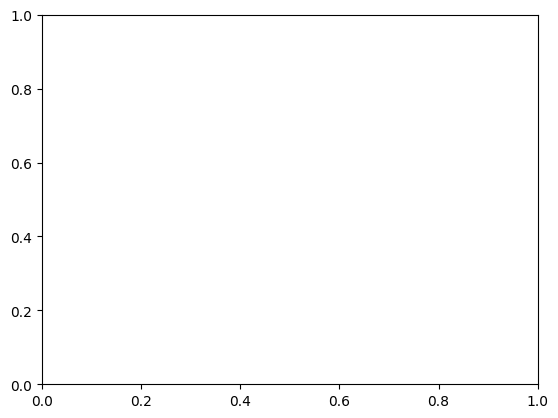

In [87]:
plt.plot(x, dataset[0, :])
plt.plot(t, y_data[0, :])

In [88]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn
'''
Cauchy-jakaumia BNN:ään. 
'''
class BNN(PyroModule):

    def __init__(self, h1, h2):
        super().__init__()
        self.fc1 = PyroModule[nn.Linear](h1, h2)
        self.fc1.weight = PyroSample(dist.Normal(0.5, 0.5).expand([h2, h1]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., 1.).expand([h2]).to_event(1))
        
        #self.fc1 = nn.Linear(h1, h2)

        self.fc2 = PyroModule[nn.Linear](h1, h2)
        self.fc2.weight = PyroSample(dist.Normal(0.5, 0.5).expand([h2, h2]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., 1.).expand([h2]).to_event(1))

        self.relu = nn.ReLU()

    def forward(self, x, y=None):
        
        x = x#.reshape(-1, 1)

        x = self.relu(self.fc1(x))#.squeeze()
        #mu = self.relu(self.fc2(x))
        mu = x
        sigma = pyro.sample("sigma", dist.Uniform(0., 0.05))
    
        with pyro.plate("data", 100):
            obs = pyro.sample("obs", dist.Normal(mu, sigma), obs=y)
        
        return mu

In [100]:
bnn_model = BNN(h1=N, h2=n)

# Set Pyro random seed
pyro.set_rng_seed(42)

nuts_kernel = pyro.infer.NUTS(bnn_model, jit_compile=True)

# Define MCMC sampler, get 50 posterior samples
bnn_mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=100)

# Convert data to PyTorch tensors
x_train = torch.from_numpy(y_data).float()
y_train = torch.from_numpy(dataset).float()
data = [x_train, y_train]
# Run MCMC
bnn_mcmc.run(x_train, y_train)

Warmup:   0%|          | 0/200 [00:00, ?it/s]/home/akseli/.venv/lib/python3.10/site-packages/pyro/poutine/subsample_messenger.py:70: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  result = torch.tensor(0.0, device=self.device)
Sample: 100%|██████████| 200/200 [03:22,  1.01s/it, step size=5.53e-04, acc. prob=0.802]


In [103]:

predictive = pyro.infer.Predictive(model=bnn_model, posterior_samples=bnn_mcmc.get_samples())
x_test = torch.linspace(domain[0], domain[1], 100)
preds = predictive(x_train[0,:])

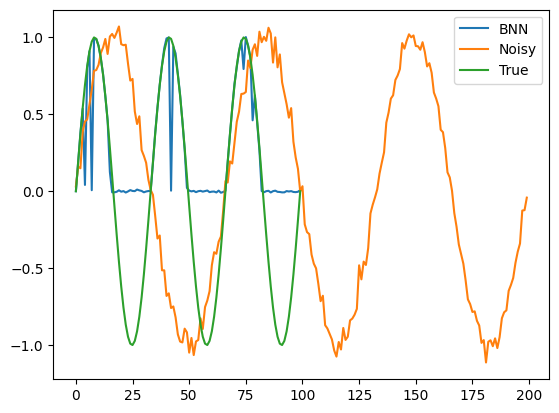

In [104]:
plt.plot(torch.mean(preds['obs'], axis=0))
plt.plot(x_train[0,:])
plt.plot(y_train[0, :])

plt.legend(['BNN', 'Noisy', 'True'])